In [1]:
import pandas as pd  #Read Data

def read_data(file_dir):
    df = pd.read_csv(file_dir)
    return df

In [56]:
import matplotlib.pyplot as plt

def visualize_data(df, col_name):
    one = 0
    zero = 0
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    for label in df[col_name]:
        if label == 1:
            one += 1
        else:
            zero += 1
    ax.bar(0.00, [one], color = 'g', width = 0.25)
    ax.bar(0.25, [zero], color = 'r', width = 0.25)

In [30]:
#Convert label to negative 0 or positive 1
import numpy

def convert_sentiment_label(df, col_name):
    index_nan = list()
    df2 = df[['Ulasan', col_name]].copy()
    df2[col_name].replace(str("pos"), 1, inplace=True)
    df2[col_name].replace(str("neg"), 0, inplace=True)
    df2[col_name].replace("", float("NaN"), inplace=True)
    df2.dropna(subset=[col_name], inplace=True)
    df2[col_name] = df2[col_name].astype(numpy.int64)
    
    return df2

def convert_aspect_label(df, col_name):
    index_nan = list()
    df2 = df[['Ulasan', col_name]].copy()
    df2[col_name].replace(float("NaN"), 0, inplace=True)
    df2[col_name].replace(str("pos"), 1, inplace=True)
    df2[col_name].replace(str("neg"), 1, inplace=True)
    df2[col_name] = df2[col_name].astype(numpy.int64)
    
    return df2

In [4]:
import sklearn
from sklearn.model_selection import train_test_split

def split_data(df, col_name, test_size):
    words = df.Ulasan.tolist()
    label = df[col_name].tolist()
    x_train, x_test, y_train, y_test = train_test_split(words, label, test_size=test_size, random_state=10)
    return x_train, x_test, y_train, y_test

In [5]:
#https://stackoverflow.com/questions/53294482/how-to-get-tf-idf-scores-for-the-words

from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorizer(x_train, x_test):
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
    vecx_train = vectorizer.fit_transform(x_train).toarray()
    vecx_test = vectorizer.transform(x_test).toarray()
    return vecx_train, vecx_test, vectorizer

In [6]:
from sklearn.naive_bayes import MultinomialNB
from time import time

def train_data_nb(x_train, x_test, y_train, y_test):
    t0 = time()
    model = MultinomialNB()
    model.fit(x_train, y_train)
    print(f"\nTraining time: {round(time()-t0, 3)}s")
    t0 = time()
    score_train = model.score(x_train, y_train)
    print(f"Prediction time (train): {round(time()-t0, 3)}s")
    t0 = time()
    score_test = model.score(x_test, y_test)
    print(f"Prediction time (test): {round(time()-t0, 3)}s")
    print("\nTrain set score:", score_train)
    print("Test set score:", score_test)
    return model

In [7]:
from sklearn import svm

def train_data_svm(x_train, x_test, y_train, y_test):
    t0 = time()
    model = svm.SVC(kernel='linear')
    model.fit(x_train, y_train)
    print(f"\nTraining time: {round(time()-t0, 3)}s")
    t0 = time()
    score_train = model.score(x_train, y_train)
    print(f"Prediction time (train): {round(time()-t0, 3)}s")
    t0 = time()
    score_test = model.score(x_test, y_test)
    print(f"Prediction time (test): {round(time()-t0, 3)}s")
    print("\nTrain set score:", score_train)
    print("Test set score:", score_test)
    return model

In [8]:
def predict_data(text, model):
    data = [text]
    vec_data = vectorizer.transform(data).toarray()
    return model.predict(vec_data)

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(model, vectorized_test_data, label):
    x_test = vectorized_test_data
    y_pred = model.predict(x_test)
    return precision_recall_fscore_support(label, y_pred, average='micro')

# Run Program!!!

In [33]:
#df = read_data("Data skripsi/fix hasil label/aspek_labeling_1.csv")
df = read_data("Data skripsi/preprocessed_data.csv")

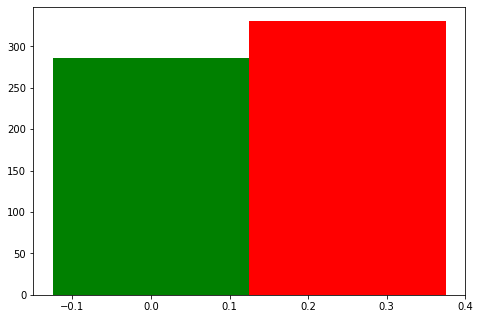

In [73]:
#aspects: 'Learnability', 'Efficiency', 'Memorability', 'Errors', 'Satisfaction'

col_name = 'Memorability'  
df_sentimen = convert_sentiment_label(df, col_name)
df_aspect = convert_aspect_label(df, col_name) 
visualize_data(df_sentimen, col_name)

In [74]:
x_train, x_test, y_train, y_test = split_data(df_sentimen, col_name, test_size= 0.2)

In [75]:
vx_train, vx_test, vectorizer = tfidf_vectorizer(x_train, x_test)

In [76]:
model_nb = train_data_nb(vx_train, vx_test, y_train, y_test)


Training time: 0.009s
Prediction time (train): 0.005s
Prediction time (test): 0.001s

Train set score: 0.9817444219066938
Test set score: 0.8548387096774194


In [77]:
evaluate_model(model_nb, vx_test, y_test)

(0.8548387096774194, 0.8548387096774194, 0.8548387096774194, None)

In [78]:
model_nb.predict(vx_test)

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0])

In [79]:
model_svm = train_data_svm(vx_train, vx_test, y_train, y_test)


Training time: 1.143s
Prediction time (train): 1.076s
Prediction time (test): 0.26s

Train set score: 1.0
Test set score: 0.9193548387096774


In [80]:
evaluate_model(model_svm, vx_test, y_test)

(0.9193548387096774, 0.9193548387096774, 0.9193548387096774, None)

In [82]:
model_svm.predict(vx_test)

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0])

In [81]:
text = "mudah"
predict_data(text, model_nb)

array([1])

In [106]:
text = "mudah"
predict_data(text, model_svm)

array([1])

In [19]:
#SOurce: https://towardsdatascience.com/training-a-naive-bayes-model-to-identify-the-author-of-an-email-or-document-17dc85fa630a